In [1]:
import OS_CNN as oscnn
import numpy as np
import matplotlib.pyplot as plt
import feature_extraction as fex
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pandas as pd

## 1D CNN 

### Load the trained model of the 36 categories: 10 numbers(0-9) + 26 letters(a-z and A-Z combined)

Features: x & y normalized with maxabscaler sample by sample and resampled to 60 points
<br>
num of samples = 9089
<br>
train: 80% 	test: 20%
<br>
epochs = 100
<br>
batch_size = 16
<br>
learning_rate = 0.005
<br>

#### Load the model

In [2]:
# file containing the model
model_folder = "./data/online_data/prepared/1D_CNN_36_classes_model/AirFinger_2/"
model_f_name = model_folder + "AirFinger_2Best_model"
# network parameters
input_shape = 60
n_class = 36
columns = 2
Max_kernel_size = 89
paramenter_number_of_layer_list = [8 * 128 * columns, 5 * 128 * 256 + 2 * 256 * 128]
receptive_field_shape = min(int(input_shape / 4), Max_kernel_size)
layer_parameter_list = oscnn.generate_layer_parameter_list(1,
                                                           receptive_field_shape,
                                                           paramenter_number_of_layer_list,
                                                           in_channel=int(columns))
# build os-cnn net and load weight
torch_FCN = oscnn.OS_CNN(layer_parameter_list, n_class, False)
torch_FCN.load_state_dict(torch.load(model_f_name))
torch_FCN.eval()  # Sets the module in evaluation mode

OS_CNN(
  (net): Sequential(
    (0): build_layer_with_layer_parameter(
      (padding): ConstantPad1d(padding=(6, 6), value=0)
      (conv1d): Conv1d(2, 168, kernel_size=(13,), stride=(1,))
      (bn): BatchNorm1d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): build_layer_with_layer_parameter(
      (padding): ConstantPad1d(padding=(6, 6), value=0)
      (conv1d): Conv1d(168, 224, kernel_size=(13,), stride=(1,))
      (bn): BatchNorm1d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): build_layer_with_layer_parameter(
      (padding): ConstantPad1d(padding=(0, 1), value=0)
      (conv1d): Conv1d(224, 336, kernel_size=(2,), stride=(1,))
      (bn): BatchNorm1d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (averagepool): AdaptiveAvgPool1d(output_size=1)
  (hidden): Linear(in_features=336, out_features=36, bias=True)
)

#### Load the data

In [3]:
X_test = np.load("data/online_data/prepared/1D_CNN_36_classes_model/X_test.npy")
y_test = np.load("data/online_data/prepared/1D_CNN_36_classes_model/y_test.npy")

X_test = torch.from_numpy(X_test)
X_test.requires_grad = False
y_test = torch.from_numpy(y_test)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)
#build dataloader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_test.shape[0] / 10, 16)), shuffle=False)

X_test shape:  torch.Size([1818, 2, 60])
y_test shape:  torch.Size([1818])


#### Predict 

In [4]:
predict_list = np.array([])
for sample in test_loader:
    y_predict = torch_FCN(sample[0])
    y_predict = y_predict.detach().cpu().numpy()
    y_predict = np.argmax(y_predict, axis=1)
    predict_list = np.concatenate((predict_list, y_predict), axis=0)

In [5]:
y_test = np.load("data/online_data/prepared/1D_CNN_36_classes_model/y_test.npy")
acc = accuracy_score(predict_list, y_test)
print("Accuracy: ",acc)

Accuracy:  0.976897689768977


#### Print confusion matrix

Normalized confusion matrix


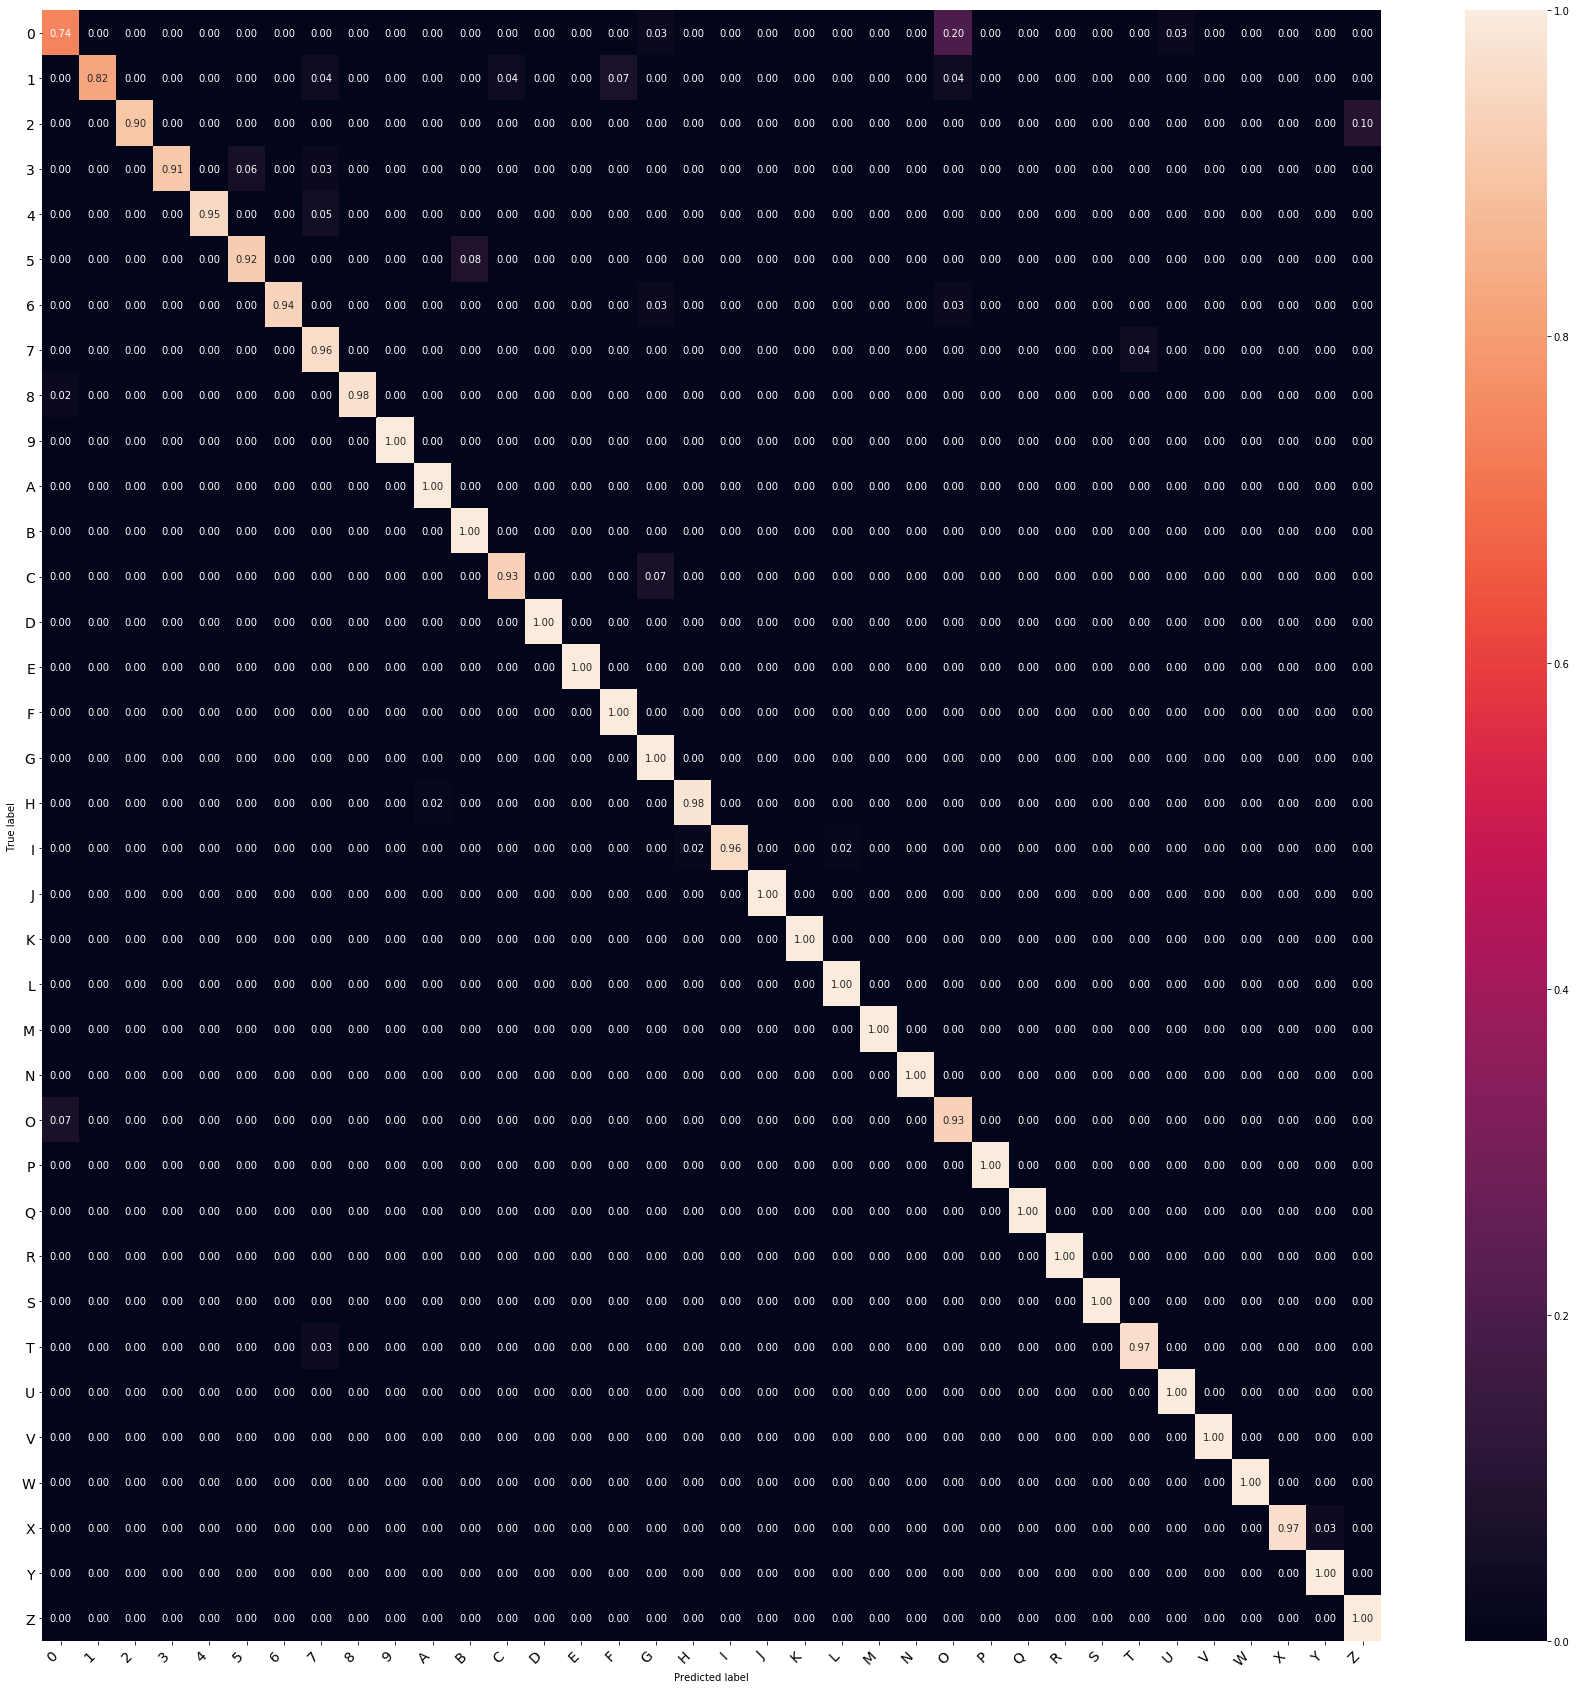

In [6]:
conf_matrix = confusion_matrix(y_test, predict_list)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A',
               'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
               'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
               'X', 'Y', 'Z']
fex.print_confusion_matrix(conf_matrix, class_names)